In [1]:
import os
import sys
sys.path.insert(0, os.path.join(os.getenv("HOME"), "linked-data-latex"))

import logging
logging.basicConfig(level="INFO")

import pandas as pd
from matplotlib import pylab as plt
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# oda:version "v0.1.3"

In [3]:
from odafunction.executors import default_execute_to_value
from odafunction.func.urifunc import URIipynbFunction, URIValue

focus_obs_name='total_3p'

# TODO: set version restriction here
# TODO: make nb2workflow store in remote storages
# TODO: make possible to disrupt equivalence with indications
# TODO: make common fd/fc depending on

v = default_execute_to_value(URIipynbFunction.from_generic_uri("file:///home/savchenk/grb221009/grbbase.ipynb")(focus_obs_name=focus_obs_name), valueclass=URIValue, cached=True)

import io
import tempfile
import base64
import tarfile
    
with tarfile.open(v['output_values']['fits_pack_url'].replace("file://", "")) as tar:
    tar.extractall(path=f"grbbase_fitspack_lc_{focus_obs_name}")

!ls -ltor grbbase_fitspack_lc*/*lc*fits

INFO:odafunction.func.urifunc:constructing <class 'odafunction.func.urifunc.URIipynbFunction'> from uri=file:///home/savchenk/grb221009/grbbase.ipynb value=None provenance=None
INFO:odafunction.func.urifunc:parsing URI file:///home/savchenk/grb22100...(45)
INFO:odafunction.func.urifunc:parsed uri file:///home/savchenk/grb221009/grbbase.ipynb as {'modifier': None, 'schema': 'file', 'path': '/home/savchenk/grb221009/grbbase.ipynb', 'funcname': None, 'revision': None}
INFO:nb2workflow.nbadapter:notebook_dir: /home/savchenk/grb221009
INFO:nb2workflow.semantics:input combined turtle: @prefix oda: <http://odahub.io/ontology#> . <http://odahub.io/ontology#grbbase_f48a57bf> a oda:version "v0.2.25" .
INFO:nb2workflow.semantics:this variation could not be parsed: @prefix oda: <http://odahub.io/ontology#> . <http://odahub.io/ontology#grbbase_f48a57bf> a oda:version "v0.2.25" . due to at line 1 of <>:
Bad syntax (expected '.' or '}' or ']' at end of statement) at ^ in:
"...b' <http://odahub.io/ont

-rw-rw-r-- 1 savchenk 23040 Feb 10 23:18 grbbase_fitspack_lc_total_3p/JMX1_lc_GRB221009A.fits
-rw-rw-r-- 1 savchenk 23040 Feb 10 23:18 grbbase_fitspack_lc_total_3p/JMX2_lc_GRB221009A.fits
-rw-rw-r-- 1 savchenk 28800 Feb 10 23:18 grbbase_fitspack_lc_total_3p/IBIS_lc_GRB221009A.fits


In [4]:
from astropy.time import Time

T0_isot = v['output_values']['data']['T0_isot']
T0_ijd = Time(T0_isot).mjd - 51544

In [5]:

from ddpaper.draftdata import load_globals

load_globals("eventinfo", globals())


INFO:ddpaper.draftdata:loading T0_ijd = 8317.553472222222
INFO:ddpaper.draftdata:loading T0_isot = '2022-10-09T13:17:00'
INFO:ddpaper.draftdata:loading source_name = 'GRB221009A'
INFO:ddpaper.draftdata:loading src_coord = <SkyCoord (ICRS): (ra, dec) in deg
    (288.26429167, 19.77308333)>


        59861.532764       -1.132263e-08
        59861.532875       -2.860962e-08
        59861.532967        8.372585e-09
        59861.533060        2.639475e-08
        59861.533152        5.800138e-08
        59861.533243        7.682774e-09
        59861.533336       -2.288027e-08
        59861.533427       -2.711575e-08
        59861.533519       -1.538258e-09
        59861.533612       -4.196331e-08


[]

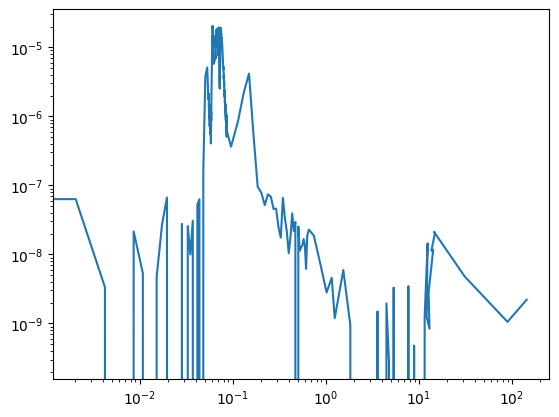

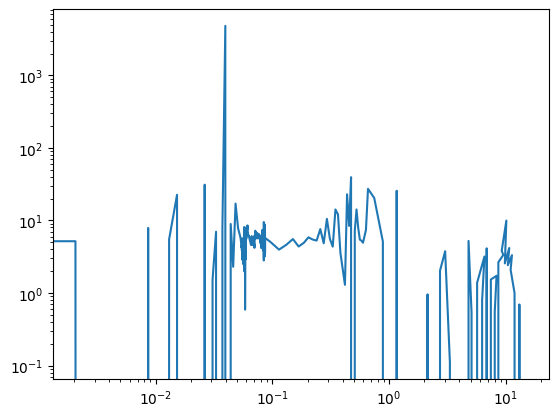

In [6]:
plt.figure()

!head picsit/grb221009a_afterglow_picsit_lc.txt

picsit_lc = pd.read_csv("picsit/grb221009a_afterglow_picsit_lc.txt", delim_whitespace=True, names=["mjd", "flux"])
picsit_hr = pd.read_csv("picsit/grb221009a_afterglow_picsit_hr.txt", delim_whitespace=True, names=["mjd", "hr"])

plt.plot(
    (picsit_lc.mjd - (T0_ijd + 51544))*24, 
    picsit_lc.flux, 
)

plt.loglog()

plt.figure()

plt.plot(
    (picsit_hr.mjd - (T0_ijd + 51544))*24, 
    picsit_hr.hr, 
)

plt.loglog()

In [7]:
import numpy as np
from rebin import rebin_in_bins



In [8]:
picsit_lc.sort_values('mjd', inplace=True)

picsit_lc['flux_err'] = picsit_lc.flux*0 + 1e-8
picsit_lc['dt']  = np.concatenate([[0], np.array(picsit_lc['mjd'])[1:] - np.array(picsit_lc['mjd'])[:-1]])

In [9]:
picsit_lc['dt'].min()

0.0

In [34]:
import ogip.core
import ogip.tools

import importlib

importlib.reload(ogip.tools)


def get_conversion(instr):
    pha = ogip.core.open_something(f"grbbase_fitspack_{focus_obs_name}/{instr}_spectrum_GRB221009A_{focus_obs_name}.fits")
    rmf = ogip.core.open_something(f"grbbase_fitspack_{focus_obs_name}/{instr}_rmf_GRB221009A_{focus_obs_name}.fits")
    arf = ogip.core.open_something(f"grbbase_fitspack_{focus_obs_name}/{instr}_arf_GRB221009A_{focus_obs_name}.fits")


    model_generator = lambda p:(lambda x:(p[0]*(x/25.)))
    fit_result, fitted_model = ogip.tools.fit(model_generator, [7e-5], pha, rmf, None, 
                                            mask=~np.isnan(pha._rate))

    # TODO: check
    return ogip.tools.get_unfolding_factor(fitted_model, rmf, arf) * u.keV.to(u.erg)


get_conversion('IBIS').mean(), 1e-8/200

INFO:root:opened grbbase_fitspack_total_3p/IBIS_spectrum_GRB221009A_total_3p.fits as <ogip.spec.PHAI object at 0x7f07413bd340>
INFO:root:opened grbbase_fitspack_total_3p/IBIS_rmf_GRB221009A_total_3p.fits as <ogip.spec.RMF object at 0x7f0713982a60>
INFO:root:opened grbbase_fitspack_total_3p/IBIS_arf_GRB221009A_total_3p.fits as <ogip.spec.ARF object at 0x7f0713982340>


(2.8255634e-11, 5e-11)

INFO:root:opened grbbase_fitspack_total_3p/JMX1_spectrum_GRB221009A_total_3p.fits as <ogip.spec.PHAI object at 0x7f0712f21d90>
INFO:root:opened grbbase_fitspack_total_3p/JMX1_rmf_GRB221009A_total_3p.fits as <ogip.spec.RMF object at 0x7f0712ed3400>
INFO:root:opened grbbase_fitspack_total_3p/JMX1_arf_GRB221009A_total_3p.fits as <ogip.spec.ARF object at 0x7f0712e45b50>
/home/savchenk/miniconda-recent/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/savchenk/miniconda-recent/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2235762/2932438005.py:28: RuntimeWarning: invalid value encountered in double_scalars
  re = rebin_in_bins(d['TIME'] - T0_ijd, d['ERROR'], T, agg=lambda x:(np.sum(x**2))**0.5/len(x))
INFO:root:opened grbbase_fitspack_total_3p/JMX1_spectrum_GRB221009A_tot

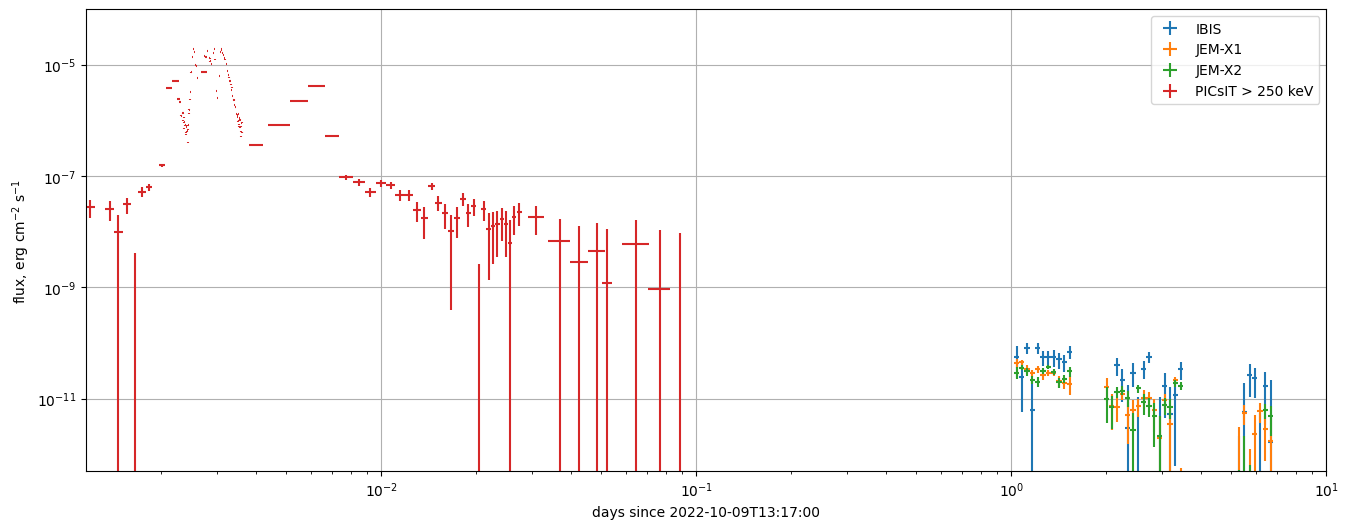

In [37]:
from astropy.io import fits


T = np.logspace(-1, 1, 120)
Tc = (T[1:] + T[:-1])/2.
dT = (T[1:] - T[:-1])/2.

plt.figure(figsize=(16, 6))

ijd2plot = lambda t:(t- T0_ijd)

plt.axhline(0, lw=2, c='k', alpha=0.5)


for label, n in [('IBIS', 'IBIS'),
                 ('JEM-X1', 'JMX1'),
                 ('JEM-X2', 'JMX2')
                ]:

    d = fits.open(f"grbbase_fitspack_lc_total_3p/{n}_lc_GRB221009A.fits")[1].data
    conversion_factor = get_conversion('JMX1').mean()

    # plt.errorbar(ijd2plot(isgri_lc['TIME']), isgri_lc['RATE'], isgri_lc['ERROR'])

    d['RATE'][d['ERROR'] > np.nanmedian(d['ERROR'])*10] = np.NaN    

    r = rebin_in_bins(d['TIME'] - T0_ijd, d['RATE'], T)
    re = rebin_in_bins(d['TIME'] - T0_ijd, d['ERROR'], T, agg=lambda x:(np.sum(x**2))**0.5/len(x))

    m = re < np.nanmedian(re)*3

    factor = 1e-8/200
    factor = conversion_factor

    plt.errorbar(
        Tc[m], 
        r[m]*factor,
        re[m]*factor,
        xerr=dT[m],
        label=label,
        ls=""
    )

m = (picsit_lc.mjd - (T0_ijd + 51544)) < 0.1

plt.errorbar(
    (picsit_lc.mjd - (T0_ijd + 51544))[m], 
    picsit_lc.flux[m],
    picsit_lc.flux_err[m],
    xerr=picsit_lc.dt[m]/2,
    ls="",
    label='PICsIT > 250 keV'
)

# TODO: picsit erange

plt.xlim([100./24/3600, 10])
plt.ylim([0.5e-12, 1e-4])

# plt.grid(which='both')
plt.grid()

plt.legend()

plt.xlabel(f"days since {T0_isot}")
plt.ylabel("flux, erg cm$^{-2}$ s$^{-1}$")

# plt.semilogx()
plt.loglog()

plt.savefig("lc.png")
plt.savefig("lc.pdf")

# TODO: plot early AG SPI-ACS
# TODO: plot model fit
# TODO: plot rings contribution approx



In [36]:
lc_pdf="lc.pdf"
comment_reconstruction="assuming slope of -2"